In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

#from imblearn.pipeline import Pipeline, make_pipeline
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('C:/Users/lyasm/OneDrive/Desktop/mimic.csv')

In [3]:
df.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1176 non-null   float64
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

In [5]:
df.shape

(1177, 51)

In [6]:
#Dropping group and ID columns as these do not provide any useful info and will no be used for analysis
df_clean = df.drop(['group','ID'], axis=1)
df_clean

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72,1,37.588179,0,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0.0,75,2,NaN,0,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0.0,83,2,26.572634,0,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0.0,43,2,83.264629,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0.0,75,2,31.824842,1,0,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,0.0,62,1,25.516870,1,1,0,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1173,0.0,78,1,25.822710,0,1,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1174,0.0,85,2,23.891779,1,1,0,1,1,0,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1175,0.0,79,2,35.288554,0,0,1,1,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


In [7]:
#Converting gender entry from as 1 and 2 to 0 and 1 for consisitency with other binary columns
df_clean['gendera'] = df_clean['gendera'] - 1
df_clean.head()

,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72,0,37.588179,0,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0.0,75,1,NaN,0,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0.0,83,1,26.572634,0,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0.0,43,1,83.264629,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0.0,75,1,31.824842,1,0,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [8]:
#Determining the number of na values for each column
df_clean.isnull().sum()

outcome                       1
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

In [9]:
#Since the outcome column is the target variable, the single missing value will not be replaced/calculated.
#It will be dropped to preserve the authencity of the outcome column.
df_clean = df_clean.dropna(subset=['outcome'])
df_clean.isnull().sum()

outcome                       0
age                           0
gendera                       0
BMI                         214
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   12
Systolic blood pressure      15
Diastolic blood pressure     15
Respiratory rate             12
temperature                  18
SP O2                        12
Urine output                 35
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophils                   259
Lymphocyte                  145
PT      

array([[<Axes: title={'center': 'outcome'}>,
        <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'gendera'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'hypertensive'}>,
        <Axes: title={'center': 'atrialfibrillation'}>,
        <Axes: title={'center': 'CHD with no MI'}>],
       [<Axes: title={'center': 'diabetes'}>,
        <Axes: title={'center': 'deficiencyanemias'}>,
        <Axes: title={'center': 'depression'}>,
        <Axes: title={'center': 'Hyperlipemia'}>,
        <Axes: title={'center': 'Renal failure'}>,
        <Axes: title={'center': 'COPD'}>,
        <Axes: title={'center': 'heart rate'}>],
       [<Axes: title={'center': 'Systolic blood pressure'}>,
        <Axes: title={'center': 'Diastolic blood pressure'}>,
        <Axes: title={'center': 'Respiratory rate'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'SP O2'}>,
        <Axes: title={'center': 'Urine output'}>,
        <

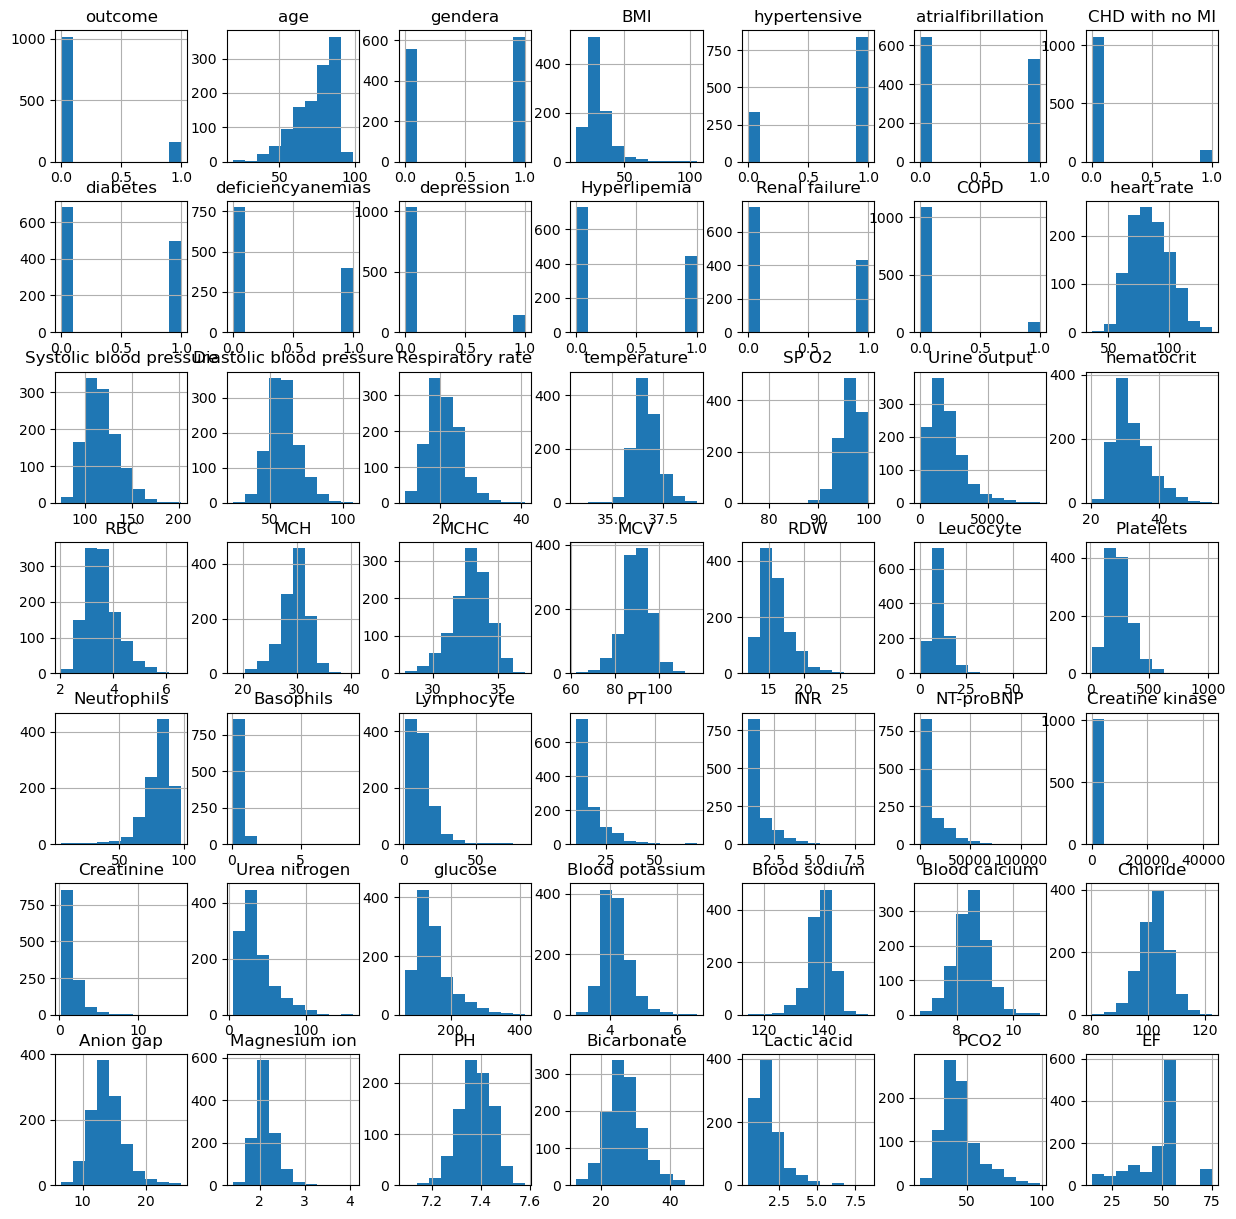

In [11]:
#Visualizing the distribution of all columns to determine which columns are normally distributed and which columns are categorical
df_clean.hist(figsize=(15,15))

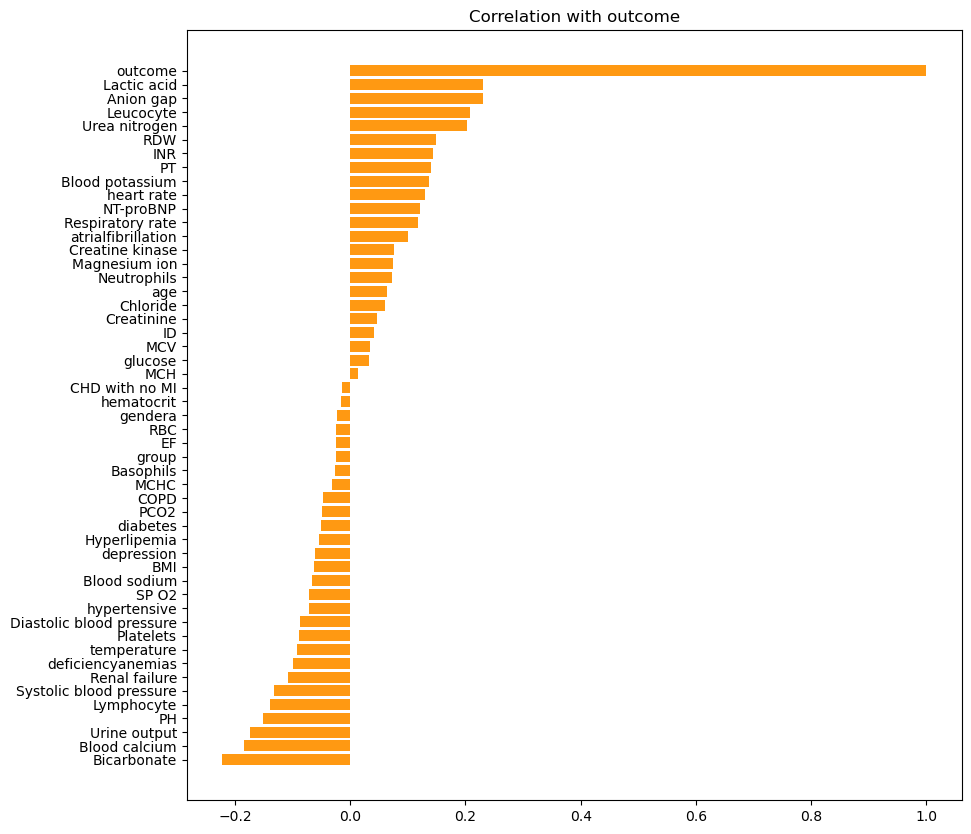

In [12]:
#Correlation Plot to show features correlation with outcome
fig = plt.figure(figsize = (10, 10))
target_corr = pd.DataFrame(df.corr()['outcome'].sort_values(ascending = True))
plt.barh(target_corr.index, target_corr['outcome'],color="#FF9912")
plt.title('Correlation with outcome')
plt.show()

In [13]:
#Creating demographic , vital signs and comorbidity data subsets for seperate analysis to determine if there is a significant effect on ICU patient mortality.

df_demo = df_clean[['outcome', 'age', 'gendera','BMI']]
df_vital = df_clean[['outcome','heart rate', 'Systolic blood pressure','Diastolic blood pressure', 'Respiratory rate','temperature','SP O2','Urine output']]
df_comorbidities = df_clean[['outcome','hypertensive','atrialfibrillation','CHD with no MI','diabetes','deficiencyanemias','depression','Hyperlipemia','Renal failure','COPD']]

In [14]:
#Imputing the missing values for using k nearest neighbours algorithm for demographic , vital and comorbidity data subsets 

df_demo_imputer = KNNImputer(missing_values=np.nan, n_neighbors=2)
df_demo_imputer.fit(df_demo)
df_demo = df_demo_imputer.transform(df_demo)

df_vital_imputer = KNNImputer(missing_values=np.nan, n_neighbors=2)
df_vital_imputer.fit(df_vital)
df_vital = df_vital_imputer.transform(df_vital)

df_comorbidities_imputer = KNNImputer(missing_values=np.nan, n_neighbors=2)
df_comorbidities_imputer.fit(df_comorbidities)
df_comorbidities = df_comorbidities_imputer.transform(df_comorbidities)

In [15]:
#Determining if demographic features have a significant effect on ICU patient mortality
#Chi-Square test on Demographic details - age

contingency_table_age = pd.crosstab(df_demo[1], df_demo[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table_age)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)


Chi-Square Statistic: 8.0
P-value: 0.23810330555354436


In [16]:
#Determining if and which vital signs have significance when predicting ICU patient mortality
# Correlation Analysis on Vital Signs - heart rate
vital_signs_hr = df_vital[1]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9993063921524408
P-value: 8.337887924375906e-10


In [17]:
# Correlation Analysis on Vital Signs - Systolic blood pressure
vital_signs_hr = df_vital[2]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9998600300645006
P-value: 6.854861806081117e-12


In [18]:
# Correlation Analysis on Vital Signs - Diastolic blood pressure
vital_signs_hr = df_vital[3]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9985902576588448
P-value: 6.996807803445467e-09


In [19]:
# Correlation Analysis on Vital Signs - Respiratory rate 
vital_signs_hr = df_vital[4]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9993871237430948
P-value: 5.752528135007677e-10


In [20]:
# Correlation Analysis on Vital Signs - temperature 
vital_signs_hr = df_vital[5]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9998817870803602
P-value: 4.129489200349259e-12


In [21]:
# Correlation Analysis on Vital Signs - SP O2 
vital_signs_hr = df_vital[6]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9996114409949746
P-value: 1.4661701501300054e-10


In [22]:
# Correlation Analysis on Vital Signs - Urine output 
vital_signs_hr = df_vital[7]
mortality = df_vital[0]

# Perform correlation analysis (Pearson)
correlation_coefficient, p_value = stats.pearsonr(vital_signs_hr, mortality)

# Display results
print("Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Correlation Coefficient: 0.9996704452929449
P-value: 8.945718273890962e-11


In [23]:
#Determining if pre-existing condition/Comorbidities have a signicant effect on ICU patient mortality
#Chi-Square test on Comorbidities - hypertensive

contingency_table = pd.crosstab(df_comorbidities[1], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)


Chi-Square Statistic: 0.0
P-value: 1.0


In [24]:
#Chi-Square test on Comorbidities - atrialfibrillation

contingency_table = pd.crosstab(df_comorbidities[2], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)


Chi-Square Statistic: 1.2760416666666665
P-value: 0.2586363197466071


In [25]:
#Chi-Square test on Comorbidities - CHD with no MI

contingency_table = pd.crosstab(df_comorbidities[3], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.0
P-value: 1.0


In [26]:
#Chi-Square test on Comorbidities - diabetes 

contingency_table = pd.crosstab(df_comorbidities[4], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.0
P-value: 1.0


In [27]:
#Chi-Square test on Comorbidities - deficiencyanemias

contingency_table = pd.crosstab(df_comorbidities[5], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.01736111111111114
P-value: 0.8951728848152466


In [28]:
#Chi-Square test on Comorbidities - depression

contingency_table = pd.crosstab(df_comorbidities[6], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.0
P-value: 1.0


In [29]:
#Chi-Square test on Comorbidities - Hyperlipemia

contingency_table = pd.crosstab(df_comorbidities[7], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.0
P-value: 1.0


In [30]:
#Chi-Square test on Comorbidities - Renal failure

contingency_table = pd.crosstab(df_comorbidities[8], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.0
P-value: 1.0


In [31]:
#Chi-Square test on Comorbidities - COPD 

contingency_table = pd.crosstab(df_comorbidities[9], df_comorbidities[0])

# Perform chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)

Chi-Square Statistic: 0.0
P-value: 1.0


In [32]:
# Splitting the dataset into 80% train set and 20% test set before imputing missing enteries to avoid data leakage

X = df_clean.iloc[:, 1:]
y = df_clean.iloc[:, 0]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [34]:
#Imputing the missing values using k nearest neighbours algorithm.
#This will take into account the relationship and pattern of the data, to resemble more real world measurements.

train_imputer_features = KNNImputer(missing_values=np.nan, n_neighbors=2)
train_imputer_features.fit(X_train)
X_train = train_imputer_features.transform(X_train)

#Important: test and train are imputed seperately to avoid overfitting
test_imputer_features = KNNImputer(missing_values=np.nan, n_neighbors=2)
test_imputer_features.fit(X_test)
X_test = test_imputer_features.transform(X_test)


In [35]:
#Standardize the data to make the mean = 0 and the standard deviation = 1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [36]:
#Setting the evaluation parameters that will be used on all of the models to compare performance

def evaluate(gt, pred):
    print('Precision: ', precision_score(gt, pred, average = 'micro'))
    print('Recall: ', recall_score(gt, pred, average = 'micro'))
    print('Accuracy: ', accuracy_score(gt, pred))
    print('F1 Score: ', f1_score(gt, pred, average = 'micro'))

In [37]:
#Setting the roc curve to be used on all of the models to compare performance

def roc_auc(model, real_X, real_y):
    y_scores = model.predict_proba(real_X)[:, 1]
    fpr, tpr, thresholds = roc_curve(real_y, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=fpr, y=tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='navy')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


In [38]:
#Logistic Regression Model

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train.ravel())

y_pred = lr_model.predict(X_test)


In [39]:
#Evaluating the Logistic Regression Model performance

evaluate(y_test, y_pred)

Precision:  0.8686440677966102
Recall:  0.8686440677966102
Accuracy:  0.8686440677966102
F1 Score:  0.8686440677966102


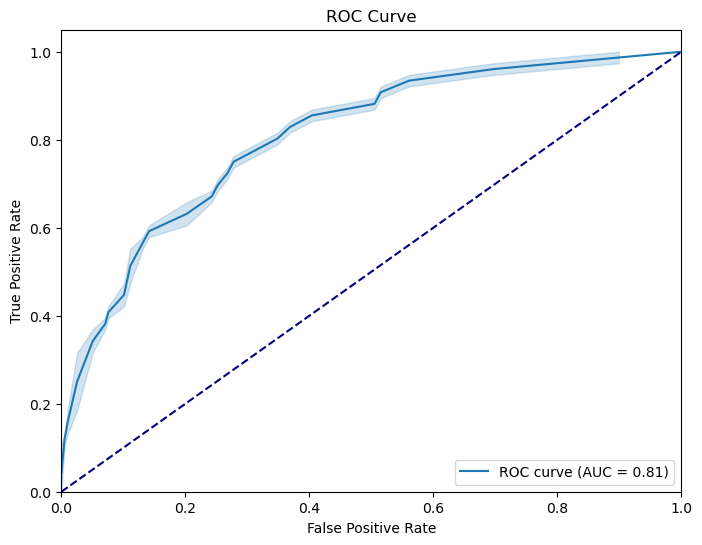

In [40]:
#Displaying the ROC for the Logistic Regression Model

roc_auc(lr_model, X_test, y_test)

In [43]:
#Conducting feature selection to determine the top 10 most influential features for predicting ICU patient mortality.
#Logistic Regression Model - Recursive Feature Elimination (RFE)

cols = list(X.columns)

lr_model_rfe = LogisticRegression()
lr_model_rfe.fit(X_train, y_train.ravel())


# Use RFE to select the top 10 features
rfe = RFE(lr_model_rfe, n_features_to_select=10)
rfe.fit(X_train, y_train.ravel())

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

# Print the selected features
print(rfe.support_)
print(rfe.ranking_)
print(selected_features_rfe)

[False False False False False False False False False False  True  True
  True False False False False False  True False False False False False
 False False False False False False False False False False  True  True
 False False False  True False  True False False  True False  True False]
[20 25 28 39 27 35 32  9 36 15  1  1  1 26  8 37 14 10  1  6  5  4  3 22
 21  2  7 16 29 17 33 18 24 23  1  1 34 11 30  1 31  1 19 13  1 12  1 38]
Index(['Renal failure', 'COPD', 'heart rate', 'Urine output', 'Creatinine',
       'Urea nitrogen', 'Blood calcium', 'Anion gap', 'Bicarbonate', 'PCO2'],
      dtype='object')


In [44]:
#Gradient Boosting Classifier

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)


In [45]:
#Evaluating the Gradient Boosting Classifier performance

evaluate(y_test, y_pred_gb)

Precision:  0.847457627118644
Recall:  0.847457627118644
Accuracy:  0.847457627118644
F1 Score:  0.847457627118644


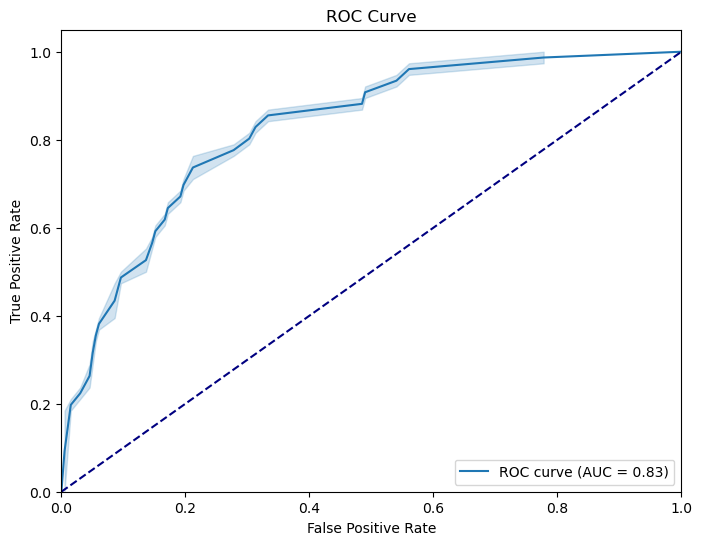

In [46]:
#Displaying the ROC for the Gradient Boosting Classifier Model

roc_auc(gb_model, X_test, y_test)

In [47]:
#Random Forest Classifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

In [48]:
#Evaluating the Random Forest Classifier performance

evaluate(y_test, y_pred_rf)

Precision:  0.847457627118644
Recall:  0.847457627118644
Accuracy:  0.847457627118644
F1 Score:  0.847457627118644


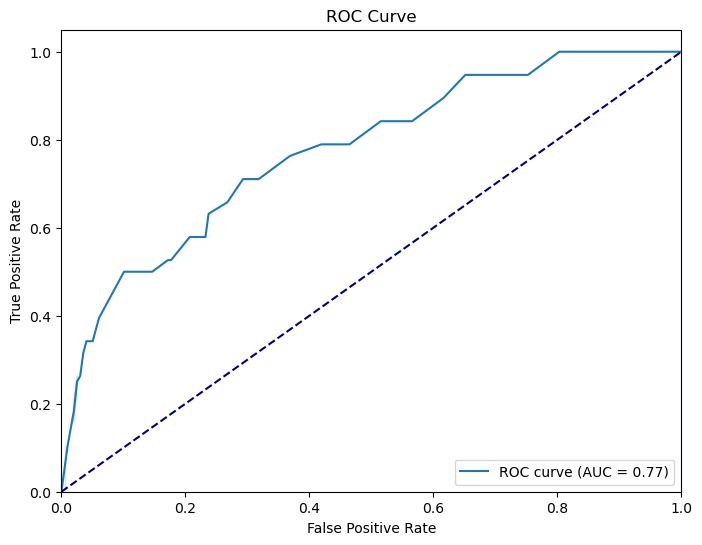

In [49]:
#Displaying the ROC for the Random Forest Classifier

roc_auc(rf_model, X_test, y_test)